# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Clustering](#clustering)
* [Cluster Analysis](#cluster_analysis)
* [Results](#results)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find best suited area for buying house in a location. This report will be useful for stakeholders interested in **house property investment** in **New York**.

**Liveability** referenced here accesses the location based on number of medical centres, outdoor & recreational activities, arts, entertainment & shopping places in that area.

New York (NY), is the most populous city in the United States, we will try to detect the **location with great liveability and suitable property price.** We are also particularly interested in areas with **less property price and good liveability**.

<a><img src ="https://raw.githubusercontent.com/patelankit706/coursera_capstone/master/applieddatasciencecapstone/images.jpg"></a>

## Data <a name="data"></a>

These are the factors affection our decision making:
* number of Medical Centres in the neighborhood
* number of Arts & Entertainment places in the neighborhood
* number of Shopping stores in the neighborhood
* number of Outdoor & Recreational places in the neighborhood
* property price in the neighborhood

Following data will be needed to extract/generate the required information:
* property price of each area in New York can be obtained by web scraping this <a href="https://www.zumper.com/blog/2019/05/nyc-by-square-foot-see-which-neighborhood-gets-you-the-most-space-for-your-money/">page</a> and their respective coordinates can be obtained using **HERE Maps API geocoding**
* parameters such as number of Medical Centers, Shopping, Arts & Outdoor Recreational places in each area will be obtained using FOURSQUARE API by using explore endpoint with category parameter


### Import libraries and download necessary dependencies

In [1]:
!pip --quiet install beautifulsoup4
!pip --quiet install lxml
!pip --quiet install html5lib
!pip --quiet install xlwt
!pip --quiet install xlrd
from bs4 import BeautifulSoup

!pip --quiet install geocoder
import geocoder

import pandas as pd
import numpy as np
import requests
import time

!pip --quiet install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pickle
import folium

### Neighborhood Candidates & Property Prices

#### Web Scraping
Let's scrap this <a href="https://www.zumper.com/blog/2019/05/nyc-by-square-foot-see-which-neighborhood-gets-you-the-most-space-for-your-money/">web page</a> in order to get property prices(dollars_per_sq_foot) of each area in New York. 

In [47]:
url="https://www.zumper.com/blog/2019/05/nyc-by-square-foot-see-which-neighborhood-gets-you-the-most-space-for-your-money/"

https_proxy  = "https://103.116.140.12:44421"
http_proxy = "http://202.29.220.34:38961"

proxyDict = { 
              "http"  : http_proxy, 
              "https" : https_proxy
            }

source = requests.get(url,proxies=proxyDict).text
soup = BeautifulSoup(source, 'lxml')
a=soup.find("table",class_="tablepress tablepress-id-541")
house_price=pd.read_html(str(a))[0]
house_price.columns=['Neighborhood','Price_per_sq_foot']
house_price.head()

,Neighborhood,Price_per_sq_foot
0,West Village,$7.68
1,Tribeca,$7.64
2,NoMad,$7.63
3,Central Park,$7.53
4,NoHo,$7.38


#### Geocoding the areas
We are using <a href="https://developer.here.com/develop/rest-apis">HERE Maps</a> and <a href="https://developer.tomtom.com/tomtom-maps-apis-developers">TomTom</a> API in order to get latitude and longitude position. 

In [48]:
tomtom_key='******'
here_app_id='******'
here_app_code='******'

def get_coordinates(address):
    try:
        #using here api
        g = geocoder.here(address,app_id=here_app_id,app_code=here_app_code)
        lat_lng_coords = g.latlng
    except:
        #using tomtom api if location not found by here api
        g=geocoder.tomtom(address,key=tomtom_key)
        lat_lng_coords=g.latlng
    return list(lat_lng_coords[0:2])

In [49]:
latitude=[]
longitude=[]

for i in house_price['Neighborhood']:
    lat,lon=get_coordinates("{}, New York, NY".format(i))
    latitude.append(lat)
    longitude.append(lon)
    
house_price['Latitude']=latitude
house_price['Longitude']=longitude

house_price.head()

,Neighborhood,Price_per_sq_foot,Latitude,Longitude
0,West Village,$7.68,40.73498,-74.00483
1,Tribeca,$7.64,40.71846,-74.00889
2,NoMad,$7.63,41.17757,-73.99850
3,Central Park,$7.53,40.78392,-73.96584
4,NoHo,$7.38,40.72982,-73.99122


In [9]:
#NoMad neighborhood in row 2 has wrong coordinates so we are updating it

address = 'NoMad, New York, NY'
geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
lat = location.latitude
lon = location.longitude

house_price.iat[2,2]=lat
house_price.iat[2,3]=lon

In [51]:
house_price['Price_per_sq_foot']=house_price['Price_per_sq_foot'].apply(lambda x:float(x[1:]))
house_price.head()

,Neighborhood,Price_per_sq_foot,Latitude,Longitude
0,West Village,7.68,40.734980,-74.004830
1,Tribeca,7.64,40.718460,-74.008890
2,NoMad,7.63,40.744688,-73.988285
3,Central Park,7.53,40.783920,-73.965840
4,NoHo,7.38,40.729820,-73.991220


#### Visualisation of obtained coordinates

In [11]:
address = 'New York, NY'

geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York are 40.7127281, -74.0060152.


In [60]:
map_ny = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# add markers to map
for lat, lng, neighborhood in zip(house_price['Latitude'],house_price['Longitude'], house_price['Neighborhood']):
    label = '{}, NY'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny)  
    
map_ny

<a><img src ="https://raw.githubusercontent.com/patelankit706/coursera_capstone/master/applieddatasciencecapstone/ny_marker.png"></a>

### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on different venues in each neighborhood.
We are only interested in venue categories given below:

|  Category             | Category id              |
|-----------------------|--------------------------|
| Arts_Entertainment    | 4d4b7104d754a06370d81259 |
| Food                  | 4d4b7105d754a06374d81259 |
| Outdoors & Recreation | 4d4b7105d754a06377d81259 |
| Medical_Center        | 4bf58dd8d48988d104941735 |
| Shop_Service          | 4d4b7105d754a06378d81259 |
| Travel_Transport      | 4d4b7105d754a06379d81259 |

The Category id's of different categories are obtained from following web page: <a href="https://developer.foursquare.com/docs/resources/categories">Foursquare Venues</a>

#### Getting number of venues in each area for different categories

In [55]:
CLIENT_ID = '******' # your Foursquare ID
CLIENT_SECRET = '******' # your Foursquare Secret
VERSION = '20180724'

In [56]:
category_dict = {
                "Arts_Entertainment" : "4d4b7104d754a06370d81259" ,
                "Food" : "4d4b7105d754a06374d81259",
                "Outdoors & Recreation" : "4d4b7105d754a06377d81259" ,
                "Medical_Center" : "4bf58dd8d48988d104941735",
                "Shop_Service" : "4d4b7105d754a06378d81259",
                "Travel_Transport" : "4d4b7105d754a06379d81259"
               }


def num_venues_near_location(lat, lon, category, client_id, client_secret, radius=500, limit=100):
    version = '20180724'
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        client_id, client_secret, version, lat, lon, category, radius, limit)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        num_venues=len(results)       
    except:
        num_venues=0
    return num_venues

In [57]:
#we have choose radius=500 to get info of 500 metre radius circular region

def get_num_venues(lats, lons):
    num_venues_dict={}
    print('Obtaining number of venues around candidate locations:', end='')
    for lat, lon in zip(lats, lons):
        for category,category_id in category_dict.items():
            num_venues = num_venues_near_location(lat, lon, category_id, CLIENT_ID, CLIENT_SECRET)
            try:
                num_venues_dict[category].append(num_venues)
            except:
                num_venues_dict[category]=[num_venues]
        print(' .', end='')
    print(' done.')
    return num_venues_dict


num_venues_dict = get_num_venues(house_price["Latitude"], house_price["Longitude"])


Obtaining number of venues around candidate locations: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.


In [58]:
for category,num in num_venues_dict.items():
    house_price[category]=num
    
house_price.head()

,Neighborhood,Price_per_sq_foot,Latitude,Longitude,Arts_Entertainment,Food,Outdoors & Recreation,Medical_Center,Shop_Service,Travel_Transport
0,West Village,7.68,40.734980,-74.004830,57,100,67,66,100,39
1,Tribeca,7.64,40.718460,-74.008890,55,100,100,100,100,60
2,NoMad,7.63,40.744688,-73.988285,68,100,100,100,100,100
3,Central Park,7.53,40.783920,-73.965840,23,4,36,43,9,3
4,NoHo,7.38,40.729820,-73.991220,85,100,100,93,100,69


In [95]:
house_price.to_excel("house_price.xls")
print("Table saved in Excel formal")

Table saved in Excel formal


In [2]:
house_price=pd.read_excel("house_price.xls").iloc[:,range(1,11)]
house_price[["Price_per_sq_foot","Arts_Entertainment","Food","Outdoors & Recreation"
             ,"Medical_Center","Shop_Service","Travel_Transport"]].describe()

,Price_per_sq_foot,Arts_Entertainment,Food,Outdoors & Recreation,Medical_Center,Shop_Service,Travel_Transport
count,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,3.048162,12.205405,36.335135,21.848649,29.637838,50.459459,19.118919
std,1.657277,21.861247,32.228567,30.057532,34.749471,35.948026,26.784708
min,0.710000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,11.000000,4.000000,5.000000,19.000000,4.000000
50%,2.450000,3.000000,25.000000,7.000000,13.000000,40.000000,7.000000
75%,3.830000,8.000000,51.000000,23.000000,43.000000,100.000000,18.000000
max,7.680000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


Clearly from above table we can find that values of column Price_per_sq_foot ranges from 0.71 to 7.68 and that of other lie between 0 to 100.

Therefore there is a need to scale these features before clustering 

## Clustering <a name="clustering"></a>

We have selected following features for clustering purpose: 
* Price_per_sq_foot
* Arts_Entertainment
* Food
* Outdoors & Recreation
* Medical_Center
* Shop_Service
* Travel_Transport

### Scaling

Now we will scale these features in range of [0,1] using min max scaler.

In [4]:
features_array=np.array(house_price.iloc[:,[1,4,5,6,7,8,9]])

scaler = MinMaxScaler()
scaler.fit(features_array)
transformed_array=scaler.transform(features_array)

transformed_array

array([[1.        , 0.57      , 1.        , ..., 0.66      , 1.        ,
        0.39      ],
       [0.99426112, 0.55      , 1.        , ..., 1.        , 1.        ,
        0.6       ],
       [0.9928264 , 0.68      , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.0143472 , 0.01      , 0.07      , ..., 0.01      , 0.04      ,
        0.04      ],
       [0.01291248, 0.01      , 0.08      , ..., 0.18      , 0.27      ,
        0.06      ],
       [0.        , 0.01      , 0.15      , ..., 0.05      , 0.3       ,
        0.08      ]])

### Optimal K
Using **Elbow method** for finding Optimal k  

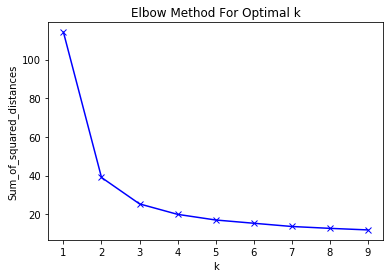

In [5]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(transformed_array)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### K Means Clustering

From the above graph we can find that the optimal value of k is 3.
Therefore we will use **k=3** for kmeans clustering.

In [16]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(transformed_array)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 0, 2, 0, 0, 2, 2, 2,
       0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0,
       2, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2,
       0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [18]:
house_price=house_price.iloc[:,[0,2,3,1,4,5,6,7,8,9]]
house_price.insert(3,"Cluster",kmeans.labels_)
house_price.head()

,Neighborhood,Latitude,Longitude,Cluster,Price_per_sq_foot,Arts_Entertainment,Food,Outdoors & Recreation,Medical_Center,Shop_Service,Travel_Transport
0,West Village,40.734980,-74.004830,1,7.68,57,100,67,66,100,39
1,Tribeca,40.718460,-74.008890,1,7.64,55,100,100,100,100,60
2,NoMad,40.744688,-73.988285,1,7.63,68,100,100,100,100,100
3,Central Park,40.783920,-73.965840,0,7.53,23,4,36,43,9,3
4,NoHo,40.729820,-73.991220,1,7.38,85,100,100,93,100,69


### Cluster Visualisation

In [19]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(house_price['Latitude'], house_price['Longitude'], house_price['Neighborhood'], house_price['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a><img src ="https://raw.githubusercontent.com/patelankit706/coursera_capstone/master/applieddatasciencecapstone/cluster.png"></a>

| Cluster  | Color  |
|----------|--------|
| Cluster 0| Red    |
| Cluster 1| Violet |
| Cluster 2| Green  |

## Cluster Analysis <a name="cluster_analysis"></a>

### Quick Analysis
 From below two graph we can see liveability of area in each cluster as follows:

| Cluster  | Liveability |
|----------|-------------|
| Cluster 0| low    |
| Cluster 1| High |
| Cluster 2| Medium  |

__Liveability:__
* For Cluster 1 liveability is high i.e. number of restaurants, hospitals, travelling, shopping and entertainment options are great but the starting property price in this region is high.

* For Cluster 2 liveability is medium i.e. compromise in either number of restaurants, hospitals, travelling, shopping and entertainment options or less property price, but budget friendly options might also be present in this cluster.

* For Cluster 0 liveability is low i.e. number of restaurants, hospitals, travelling, shopping and entertainment options are less.

In [52]:
def plot_new(ClusterAnalysis,txt):
    plt.style.use('seaborn-darkgrid')
    palette = plt.get_cmap('Set1')
    num=0
    for i in ClusterAnalysis.columns:
        num+=1
        plt.plot(ClusterAnalysis.index, ClusterAnalysis[i],color=palette(num)) 
        plt.tick_params(labelrotation=90,labelsize=10,width=2,length=2)
    fig=plt.gcf()
    fig.set_figheight(5)
    fig.set_figwidth(10)
    fig.suptitle(txt)
    plt.legend(ClusterAnalysis.columns,fontsize=17)
    plt.show()

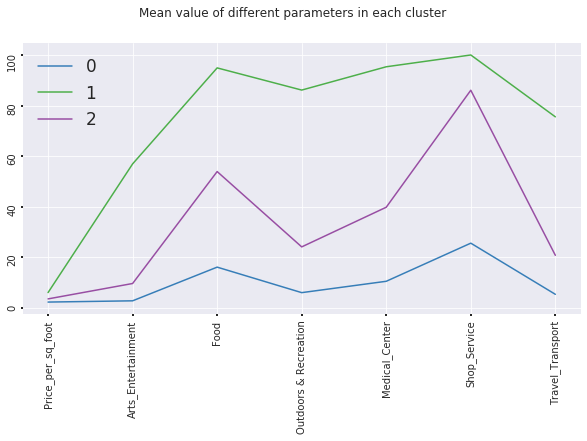

In [53]:
ClusterAnalysis=house_price.iloc[:,3:].groupby(["Cluster"]).mean().transpose()
plot_new(ClusterAnalysis,"Mean value of different parameters in each cluster")

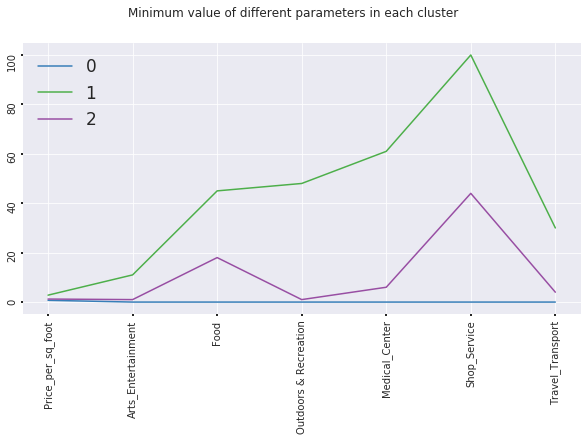

In [54]:
ClusterAnalysis=house_price.iloc[:,3:].groupby(["Cluster"]).min().transpose()
plot_new(ClusterAnalysis,"Minimum value of different parameters in each cluster")

### Deep Analysis

#### Cluster 1

The property price in this cluster ranges from 2.80 to 7.68 dollar per sq foot which is quite high because the liveability is very high in these places.

If your budget is above 2.80 dollar, some of the best places to buy house in this cluster
* **East New York** with lowest price of 2.80 dollar per sq foot
* **Little Italy** with price of 4.90 dollar per sq foot
* **Turtle Bay** with price of 4.99 dollar per sq foot

and so on

In [104]:
cluster1=house_price[house_price["Cluster"]==1]
cluster1_best=cluster1.sort_values(['Price_per_sq_foot'])
cluster1_best

,Neighborhood,Latitude,Longitude,Cluster,Price_per_sq_foot,Arts_Entertainment,Food,Outdoors & Recreation,Medical_Center,Shop_Service,Travel_Transport
68,East New York,40.728040,-73.984990,1,2.80,64,100,61,89,100,62
36,Little Italy,40.718920,-73.996090,1,4.90,70,100,87,100,100,88
34,Turtle Bay,40.759250,-73.965030,1,4.99,27,91,100,100,100,73
33,Chinatown,40.716470,-73.996760,1,5.00,57,100,61,100,100,96
32,Upper East Side,40.770440,-73.957170,1,5.03,11,100,49,100,100,47
30,Midtown East,40.758800,-73.972910,1,5.13,58,100,100,100,100,100
26,Battery Park City,40.711320,-74.015900,1,5.20,23,45,86,95,100,58
23,Civic Center,40.713370,-74.003810,1,5.35,47,76,100,100,100,71
22,Kips Bay,40.742130,-73.977820,1,5.40,16,84,58,100,100,67
20,Garment District,40.754400,-73.991850,1,5.43,100,100,100,100,100,100


#### Cluster 2
The property prices in this cluster ranges from 1.22 to 6.37 dollar per sq foot. 

If you budget ranges from 1.22 to 2.80 dollar the best places in this cluster with medium liveability are
* Concourse with a price of 1.22
* Fordham Manor with a price of 1.80
* Fordham heights with a price of 2.28

  and so on

In [98]:
cluster2=house_price[house_price["Cluster"]==2]
cluster2.sort_values(['Price_per_sq_foot'])

,Neighborhood,Latitude,Longitude,Cluster,Price_per_sq_foot,Arts_Entertainment,Food,Outdoors & Recreation,Medical_Center,Shop_Service,Travel_Transport
176,Concourse,40.82764,-73.92534,2,1.22,7,67,28,12,89,10
153,Fordham Manor,40.86476,-73.89536,2,1.80,9,35,11,29,100,23
129,Van Nest,40.84904,-73.86463,2,2.07,6,32,4,14,76,10
120,Fort Hamilton,40.61913,-74.03504,2,2.12,4,41,11,37,58,10
119,Norwood,40.87869,-73.87929,2,2.13,4,51,11,59,52,15
117,Pelham Parkway,40.85443,-73.86434,2,2.17,5,34,7,33,87,9
106,Fordham Heights,40.85894,-73.89886,2,2.28,7,45,8,36,100,18
102,Sunset Park,40.64558,-74.00983,2,2.31,9,25,5,14,89,5
101,Elmhurst,40.73869,-73.87808,2,2.34,3,79,5,44,89,12
99,Borough Park,40.63383,-73.99694,2,2.37,1,22,2,36,73,10


Consider places in below table for buying house in Cluster 2

In [105]:
clustertemp2=cluster2
for i in cluster1.columns[5:]:
    clustertemp2=clustertemp2[clustertemp2[i]>=7]
    
cluster2_best=clustertemp2[clustertemp2['Price_per_sq_foot']<2.80].sort_values(['Price_per_sq_foot'])
cluster2_best

,Neighborhood,Latitude,Longitude,Cluster,Price_per_sq_foot,Arts_Entertainment,Food,Outdoors & Recreation,Medical_Center,Shop_Service,Travel_Transport
176,Concourse,40.82764,-73.92534,2,1.22,7,67,28,12,89,10
153,Fordham Manor,40.86476,-73.89536,2,1.80,9,35,11,29,100,23
106,Fordham Heights,40.85894,-73.89886,2,2.28,7,45,8,36,100,18
93,Forest Hills,40.72232,-73.84460,2,2.44,11,48,30,100,100,14


#### Cluster 0
The property prices in this cluster ranges from 0.71 to 7.53 dollar per sq foot. 

The lowest property price is in Highbridge, Oakwood, Prince's Bay ,Clifton and Woodrock below 1 dollar per sq foot

The best places in this cluster with fair liveability if you budget is below 1.22 dollar are
* Woodrow with a price of 0.91
* Auburndale with a price of 1.03
* Morris Heights with aprice of 1.12

In [94]:
cluster0=house_price[house_price["Cluster"]==0]
cluster0.sort_values(["Price_per_sq_foot"])

,Neighborhood,Latitude,Longitude,Cluster,Price_per_sq_foot,Arts_Entertainment,Food,Outdoors & Recreation,Medical_Center,Shop_Service,Travel_Transport
184,Highbridge,40.83849,-73.92599,0,0.71,1,15,4,5,30,8
183,Oakwood,40.56390,-74.11638,0,0.80,1,8,6,18,27,6
182,Prince's Bay,40.52866,-74.19844,0,0.81,1,7,1,1,4,4
181,Clifton,40.61998,-74.07732,0,0.82,1,6,6,6,7,5
180,Woodrow,40.54316,-74.19761,0,0.91,2,3,3,7,6,2
...,...,...,...,...,...,...,...,...,...,...,...
44,Utopia,40.72732,-73.78677,0,4.00,1,35,5,44,37,4
40,West Harlem,40.81571,-73.93445,0,4.10,7,25,19,12,26,17
39,Queens Village,40.71595,-73.74217,0,4.27,3,13,9,5,36,3
37,Long Island City,40.75499,-73.94270,0,4.50,2,11,13,2,40,23


Consider places in below table for buying house in Cluster 0

In [106]:
clustertemp0=cluster0
for i in cluster0.columns[5:]:
    clustertemp0=clustertemp0[clustertemp0[i]>=2]
    
cluster0_best=clustertemp0[clustertemp0['Price_per_sq_foot']<1.22].sort_values(['Price_per_sq_foot'])
cluster0_best

,Neighborhood,Latitude,Longitude,Cluster,Price_per_sq_foot,Arts_Entertainment,Food,Outdoors & Recreation,Medical_Center,Shop_Service,Travel_Transport
180,Woodrow,40.54316,-74.19761,0,0.91,2,3,3,7,6,2
178,Auburndale,40.75861,-73.78574,0,1.03,3,24,5,65,32,7
177,Morris Heights,40.84971,-73.91985,0,1.12,3,8,7,8,33,3


## Results <a name="results"></a>

Below are the best places to invest in home property according to your budget and liveability standards:

__Budget above 2.80__

In [108]:
cluster1_best

,Neighborhood,Latitude,Longitude,Cluster,Price_per_sq_foot,Arts_Entertainment,Food,Outdoors & Recreation,Medical_Center,Shop_Service,Travel_Transport
68,East New York,40.728040,-73.984990,1,2.80,64,100,61,89,100,62
36,Little Italy,40.718920,-73.996090,1,4.90,70,100,87,100,100,88
34,Turtle Bay,40.759250,-73.965030,1,4.99,27,91,100,100,100,73
33,Chinatown,40.716470,-73.996760,1,5.00,57,100,61,100,100,96
32,Upper East Side,40.770440,-73.957170,1,5.03,11,100,49,100,100,47
30,Midtown East,40.758800,-73.972910,1,5.13,58,100,100,100,100,100
26,Battery Park City,40.711320,-74.015900,1,5.20,23,45,86,95,100,58
23,Civic Center,40.713370,-74.003810,1,5.35,47,76,100,100,100,71
22,Kips Bay,40.742130,-73.977820,1,5.40,16,84,58,100,100,67
20,Garment District,40.754400,-73.991850,1,5.43,100,100,100,100,100,100


__Budget between 1.22 to 2.80__

In [109]:
cluster2_best

,Neighborhood,Latitude,Longitude,Cluster,Price_per_sq_foot,Arts_Entertainment,Food,Outdoors & Recreation,Medical_Center,Shop_Service,Travel_Transport
176,Concourse,40.82764,-73.92534,2,1.22,7,67,28,12,89,10
153,Fordham Manor,40.86476,-73.89536,2,1.80,9,35,11,29,100,23
106,Fordham Heights,40.85894,-73.89886,2,2.28,7,45,8,36,100,18
93,Forest Hills,40.72232,-73.84460,2,2.44,11,48,30,100,100,14


__Budget below 1.22__

In [110]:
cluster0_best

,Neighborhood,Latitude,Longitude,Cluster,Price_per_sq_foot,Arts_Entertainment,Food,Outdoors & Recreation,Medical_Center,Shop_Service,Travel_Transport
180,Woodrow,40.54316,-74.19761,0,0.91,2,3,3,7,6,2
178,Auburndale,40.75861,-73.78574,0,1.03,3,24,5,65,32,7
177,Morris Heights,40.84971,-73.91985,0,1.12,3,8,7,8,33,3


# Thank You !!!!